In [64]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [65]:
train = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv')

In [66]:
train_original=train.copy()

In [67]:
train.shape

(31962, 3)

In [68]:
train_original

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [69]:
test = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/test.csv')

In [70]:
test_original=test.copy()

#### Here we see that there are a total of 17197 tweets in the test dataset

In [71]:
test.shape

(17197, 2)

In [72]:
test_original

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
...,...,...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."


### We combine Train and Test datasets for pre-processing stage

In [73]:
combine = train.append(test,ignore_index=True,sort=True)

In [74]:
combine.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


In [75]:
combine.tail()

,id,label,tweet
49154,49155,NaN,thought factory: left-right polarisation! #tru...
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverre...
49156,49157,NaN,#hillary #campaigned today in #ohio((omg)) &am...
49157,49158,NaN,"happy, at work conference: right mindset leads..."
49158,49159,NaN,"my song ""so glad"" free download! #shoegaze ..."


Given below is a user-defined function to remove unwanted text patterns from the tweets. It takes two arguments, one is the original string of text and the other is the pattern of text that we want to remove from the string. The function returns the same input string but without the given pattern. We will use this function to remove the pattern ‘@user’ from all the tweets in our data.


In [76]:
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text
        

In [77]:
combine['Tidy_Tweets'] = np.vectorize(remove_pattern)(combine['tweet'], "@[\w]*")

combine.head()

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


Punctuations, numbers and special characters do not help much. It is better to remove them from the text just as we removed the twitter handles. Here we will replace everything except characters and hashtags with spaces.

In [78]:
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("[^a-zA-Z#]", " ", regex=True)

In [79]:
combine.head(10)

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams ...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here i m it s so #gr


We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [80]:
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

combine.head(10)

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fare talking before they leave chaos disp...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,next school year year exams think about that #...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,love land #allin #cavs #champions #cleveland #...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here


Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [81]:
tokenized_tweet = combine['Tidy_Tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: Tidy_Tweets, dtype: object

Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”

In [82]:
from nltk import PorterStemmer

ps = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])

tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: Tidy_Tweets, dtype: object

#### Now let’s stitch these tokens back together.

In [83]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combine['Tidy_Tweets'] = tokenized_tweet
combine.head()

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit caus they offer wheelchair ...
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


#### Importing Packages necessary for generating a WordCloud

In [84]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

 #### Store all the words from the dataset which are non-racist/sexist

In [85]:
all_words_positive = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==0])

#### We can see most of the words are positive or neutral. With happy, smile, and love being the most frequent ones. Hence, most of the frequent words are compatible with the sentiment which is non racist/sexists tweets. 

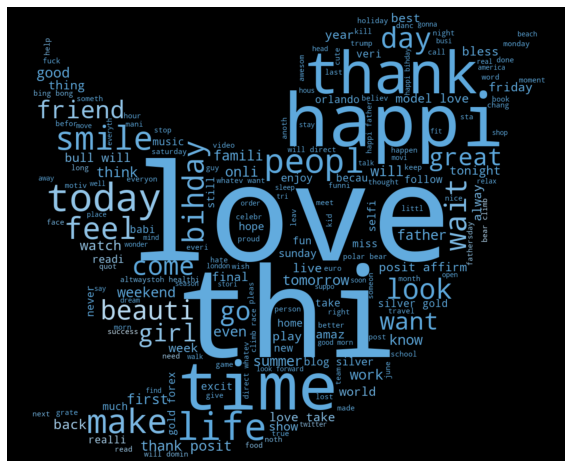

In [86]:
# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_positive)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

#### Store all the words from the dataset which are racist/sexist

In [87]:
all_words_negative = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==1])

#### As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on.

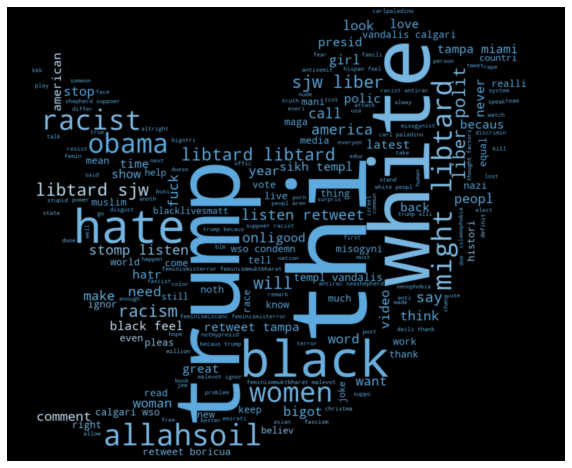

In [88]:
# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_negative)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="gaussian")

plt.axis('off')
plt.show()

### Function to extract hashtags from tweets

In [89]:
def Hashtags_Extract(x):
    hashtags=[]
    
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    
    return hashtags

#### A nested list of all the hashtags from the positive reviews from the dataset

In [90]:
ht_positive = Hashtags_Extract(combine['Tidy_Tweets'][combine['label']==0])

#### Here we unnest the list 

In [91]:
ht_positive_unnest = sum(ht_positive,[])

#### A nested list of all the hashtags from the negative reviews from the dataset

In [92]:
ht_negative = Hashtags_Extract(combine['Tidy_Tweets'][combine['label']==1])

#### Here we unnest the list

In [93]:
ht_negative_unnest = sum(ht_negative,[])

#### Counting the frequency of the words having Positive Sentiment 

In [94]:
word_freq_positive = nltk.FreqDist(ht_positive_unnest)

word_freq_positive

FreqDist({'love': 1654, 'posit': 917, 'smile': 676, 'healthi': 573, 'thank': 534, 'fun': 463, 'life': 425, 'affirm': 423, 'summer': 390, 'model': 375, ...})

#### Creating a dataframe for the most frequently used words in hashtags

In [95]:
df_positive = pd.DataFrame({'Hashtags':list(word_freq_positive.keys()),'Count':list(word_freq_positive.values())})

In [96]:
df_positive.head(10)

,Hashtags,Count
0,run,72
1,lyft,2
2,disapoint,1
3,getthank,2
4,model,375
5,motiv,202
6,allshowandnogo,1
7,school,30
8,exam,9
9,hate,27


#### Plotting the barplot for the 10 most frequent words used for hashtags 

In [97]:
df_positive_plot = df_positive.nlargest(20,columns='Count') 

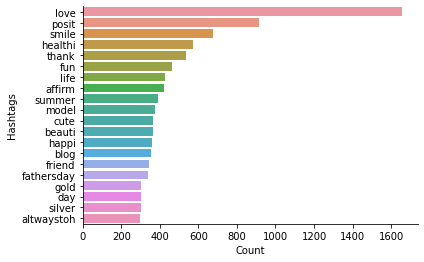

In [98]:
sns.barplot(data=df_positive_plot,y='Hashtags',x='Count')
sns.despine()

#### Counting the frequency of the words having Negative Sentiment 

In [99]:
word_freq_negative = nltk.FreqDist(ht_negative_unnest)

In [100]:
word_freq_negative

FreqDist({'trump': 136, 'polit': 95, 'allahsoil': 92, 'liber': 81, 'libtard': 77, 'sjw': 75, 'retweet': 63, 'black': 46, 'miami': 46, 'hate': 37, ...})

#### Creating a dataframe for the most frequently used words in hashtags

In [101]:
df_negative = pd.DataFrame({'Hashtags':list(word_freq_negative.keys()),'Count':list(word_freq_negative.values())})

In [102]:
df_negative.head(10)

,Hashtags,Count
0,cnn,10
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,5
5,seashepherd,22
6,helpcovedolphin,3
7,thecov,4
8,neverump,8
9,xenophobia,12


#### Plotting the barplot for the 10 most frequent words used for hashtags 

In [103]:
df_negative_plot = df_negative.nlargest(20,columns='Count') 

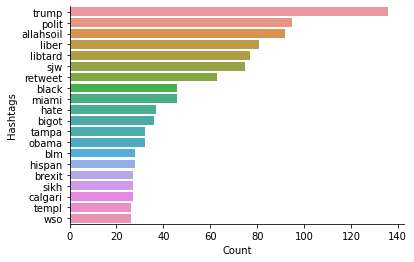

In [104]:
sns.barplot(data=df_negative_plot,y='Hashtags',x='Count')
sns.despine()

### Bag-of-Words Features

### TF-IDF Features

# Applying Machine Learning Models

### Using features from TF-IDF for training set

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(combine['Tidy_Tweets'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
train_tfidf_matrix = tfidf_matrix[:31962]

train_tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

### Splitting the data into training and validation set

In [107]:
from sklearn.model_selection import train_test_split

#### Using TF-IDF features

In [108]:
x_train_tfidf,x_valid_tfidf,y_train_tfidf,y_valid_tfidf = train_test_split(train_tfidf_matrix,train['label'],test_size=0.3,random_state=17)


## Logistic Regression

In [109]:
from sklearn.linear_model import LogisticRegression

In [110]:
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')

#### Calculating the F1 score

### Using TF-IDF Features

In [111]:
Log_Reg.fit(x_train_tfidf,y_train_tfidf)

LogisticRegression(random_state=0)

In [112]:
prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)

prediction_tfidf

array([[0.98487907, 0.01512093],
       [0.97949889, 0.02050111],
       [0.9419737 , 0.0580263 ],
       ...,
       [0.98630906, 0.01369094],
       [0.96746188, 0.03253812],
       [0.99055287, 0.00944713]])

#### Calculating the F1 score and Accuracy

In [113]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [114]:
prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)


In [115]:
# calculating f1 score
log_score = f1_score(y_valid_tfidf, prediction_int)
log_score

0.5862068965517241

In [116]:
log_accuracy = accuracy_score(y_valid_tfidf,prediction_int)
log_accuracy

0.9499426426113254

## XGBoost

In [117]:
from xgboost import XGBClassifier

### Using TF-IDF Features 

In [118]:
model_tfidf=XGBClassifier(random_state=29,learning_rate=0.7)

In [119]:
model_tfidf.fit(x_train_tfidf, y_train_tfidf)

/home/hertz/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[04:12:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.7, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=29,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
# The first part of the list is predicting probabilities for label:0 
# and the second part of the list is predicting probabilities for label:1
xgb_tfidf=model_tfidf.predict_proba(x_valid_tfidf)

xgb_tfidf

array([[0.9958908 , 0.00410918],
       [0.9872918 , 0.01270822],
       [0.9527768 , 0.04722321],
       ...,
       [0.99192214, 0.00807783],
       [0.9852176 , 0.01478244],
       [0.9974108 , 0.0025892 ]], dtype=float32)

#### Calculating the F1 score and accuracy


In [121]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
xgb_tfidf=xgb_tfidf[:,1]>=0.3

# converting the results to integer type
xgb_int_tfidf=xgb_tfidf.astype(np.int)

# calculating f1 score
xbg_score=f1_score(y_valid_tfidf,xgb_int_tfidf)

xbg_score

0.5792

In [122]:
xbg_accuracy = accuracy_score(y_valid_tfidf,xgb_int_tfidf)
xbg_accuracy

0.9451454791949109

## Random Forest

In [123]:
from sklearn.tree import DecisionTreeClassifier

In [124]:
rfc = RandomForestClassifier(n_estimators=100)

### Using TF-IDF Features

In [125]:
rfc.fit(x_train_tfidf,y_train_tfidf)

RandomForestClassifier()

In [126]:
rfc_pred = rfc.predict_proba(x_valid_tfidf)

rfc_pred

array([[1.        , 0.        ],
       [0.99      , 0.01      ],
       [0.97728919, 0.02271081],
       ...,
       [0.97      , 0.03      ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

#### Calculating F1 Score and accuracy

In [127]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
rfc_pred=rfc_pred[:,1]>=0.3

# converting the results to integer type
rfc_int_tfidf=rfc_pred.astype(np.int)

# calculating f1 score
rfc_score=f1_score(y_valid_tfidf,rfc_int_tfidf)
rfc_score

0.5845932325413967

In [128]:
rfc_accuracy = accuracy_score(y_valid_tfidf, rfc_int_tfidf )
rfc_accuracy

0.9398268849723642

# Multinomial Naive Bayes


In [129]:
nb = MultinomialNB()
nb.fit(x_train_tfidf,y_train_tfidf)

MultinomialNB()

In [130]:
nb_model = nb.predict_proba(x_valid_tfidf)
nb_model

array([[0.98964835, 0.01035165],
       [0.98483677, 0.01516323],
       [0.93394562, 0.06605438],
       ...,
       [0.99043021, 0.00956979],
       [0.9480211 , 0.0519789 ],
       [0.99326839, 0.00673161]])

### Calculating F1 Score and accuracy

In [131]:
nb_model=nb_model[:,1]>=0.3

# converting the results to integer type
nb_model=nb_model.astype(np.int)

# calculating f1 score
naive_bays_score=f1_score(y_valid_tfidf,nb_model)

naive_bays_score

0.551111111111111

In [132]:
naive_bays_accuracy = accuracy_score(y_valid_tfidf,nb_model)
naive_bays_accuracy

0.9473354885806653

# Linear support vector

In [133]:
from sklearn.calibration import CalibratedClassifierCV

In [134]:
lsvc = LinearSVC()
lsvc.fit(x_train_tfidf,y_train_tfidf)

LinearSVC()

In [135]:
lsvc_new = CalibratedClassifierCV(lsvc,cv='prefit')
lscv_new = lsvc_new.fit(x_valid_tfidf,y_valid_tfidf) 
lsvc_model = lsvc_new.predict_proba(x_valid_tfidf)
lsvc_model

array([[0.97495605, 0.02504395],
       [0.99219158, 0.00780842],
       [0.95558876, 0.04441124],
       ...,
       [0.99559536, 0.00440464],
       [0.96969686, 0.03030314],
       [0.99709221, 0.00290779]])

### Calculating F1 Score and accuracy

In [136]:
lsvc_model=lsvc_model[:,1]>=0.3

# converting the results to integer type
lsvc_model=lsvc_model.astype(np.int)

# calculating f1 score
lsvc_score=f1_score(y_valid_tfidf,lsvc_model)

lsvc_score

0.5845896147403684

In [137]:
lsvc_accuracy = accuracy_score(y_valid_tfidf,lsvc_model)
lsvc_accuracy

0.948274064031703

# Model Comparison

In [138]:
Algo=['LogisticRegression','XGBoost','RandomForest','NaiveBays','LinearSVC']

In [139]:
score = [log_score,xbg_score,rfc_score,naive_bays_score,lsvc_score]

compare=pd.DataFrame({'Model':Algo,'F1-Score':score},index=[i for i in range(1,6)])

In [140]:
compare.T

,1,2,3,4,5
Model,LogisticRegression,XGBoost,RandomForest,NaiveBays,LinearSVC
F1-Score,0.586207,0.5792,0.584593,0.551111,0.58459


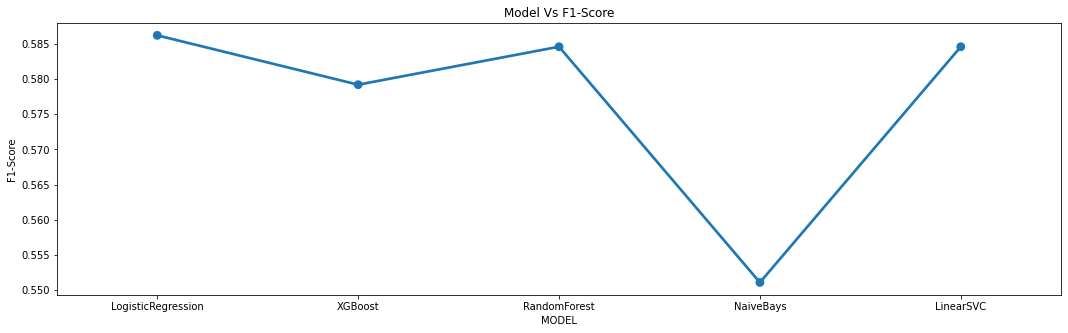

In [141]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1-Score',data=compare)

plt.title('Model Vs F1-Score')
plt.xlabel('MODEL')
plt.ylabel('F1-Score')

plt.show()

In [142]:
accuracy = [log_accuracy,xbg_accuracy,rfc_accuracy,naive_bays_accuracy,lsvc_accuracy]

compare=pd.DataFrame({'Model':Algo,'Accuracy':accuracy},index=[i for i in range(1,6)])

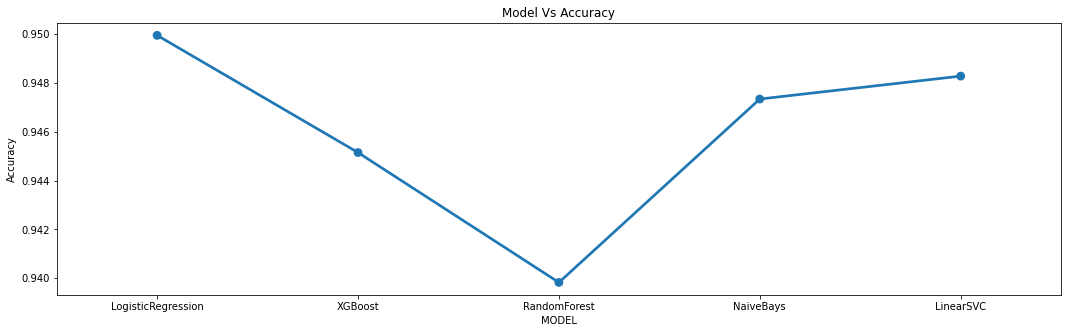

In [143]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='Accuracy',data=compare)

plt.title('Model Vs Accuracy')
plt.xlabel('MODEL')
plt.ylabel('Accuracy')

plt.show()

In [144]:
compare.T

,1,2,3,4,5
Model,LogisticRegression,XGBoost,RandomForest,NaiveBays,LinearSVC
Accuracy,0.949943,0.945145,0.939827,0.947335,0.948274


## Using the best possible model to predict for the test data

#### From the above comaprison graph we can see that Logistic Regression trained using TF-IDF features gives us the best performance

In [145]:
test_tfidf = tfidf_matrix[31962:]

In [146]:
test_pred = Log_Reg.predict_proba(test_tfidf)

test_pred_int = test_pred[:,1] >= 0.3

test_pred_int = test_pred_int.astype(np.int)

test['label'] = test_pred_int

submission = test[['id','label']]

submission.to_csv('result.csv', index=False)

### Test dataset after prediction

In [147]:
res = pd.read_csv('result.csv')

In [148]:
res

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,0
17195,49158,0


/home/hertz/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


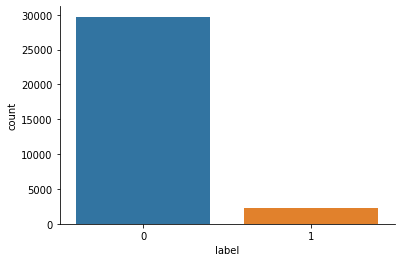

In [149]:
sns.countplot(train_original['label'])
sns.despine()